In [1]:
# Data managing
import glob
import pickle
import tqdm
import pandas as pd

# Data augmentation
import albumentations

# Computations
import numpy as np
import torch
import torch.nn as nn

import torchvision.transforms as transforms

# Image managing and visualization
from cv2 import imread
from IPython.display import Image
import matplotlib.pyplot as plt

## Training data description

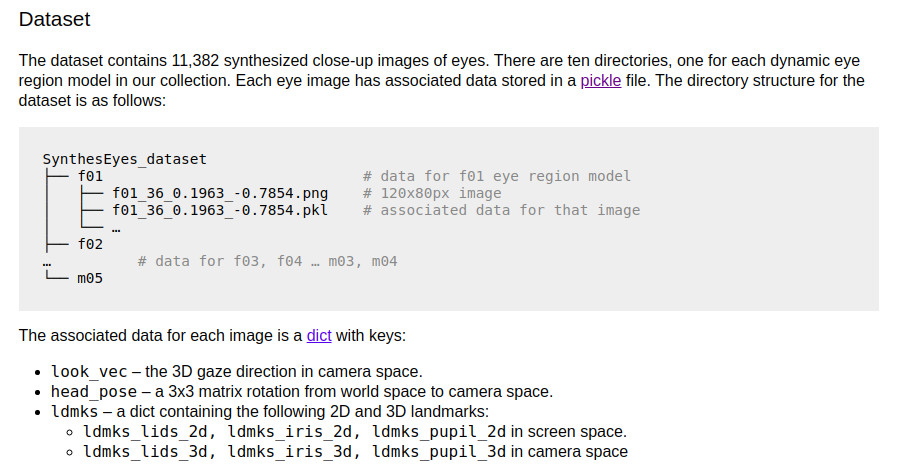

In [2]:
Image('SynthesEyesStruct.jpg')

In [3]:
listed_images = np.array(sorted(glob.glob('**/*.png',recursive=True)))
listed_data = np.array(sorted(glob.glob('**/*.pkl',recursive=True)))
print("images length : {}, data length : {}".format(len(listed_images), len(listed_data)))

images length : 11382, data length : 11382


In [4]:
def get_pickle_dicts(pickle_data):
    look_vec = pickle_data['look_vec']
    head_pose = pickle_data['head_pose']
    ldmks = pickle_data['ldmks']
    return zip(look_vec, head_pose, ldmks)

def get_2d_landmarks(data):
    return zip(data['ldmks_lids_2d'], data['ldmks_iris_2d'], data['ldmks_pupil_2d'])

def get_3d_landmarks(data):
    return zip(data['ldmks_lids_3d'], data['ldmks_iris_3d'], data['ldmks_pupil_3d'])

## Training data visualization

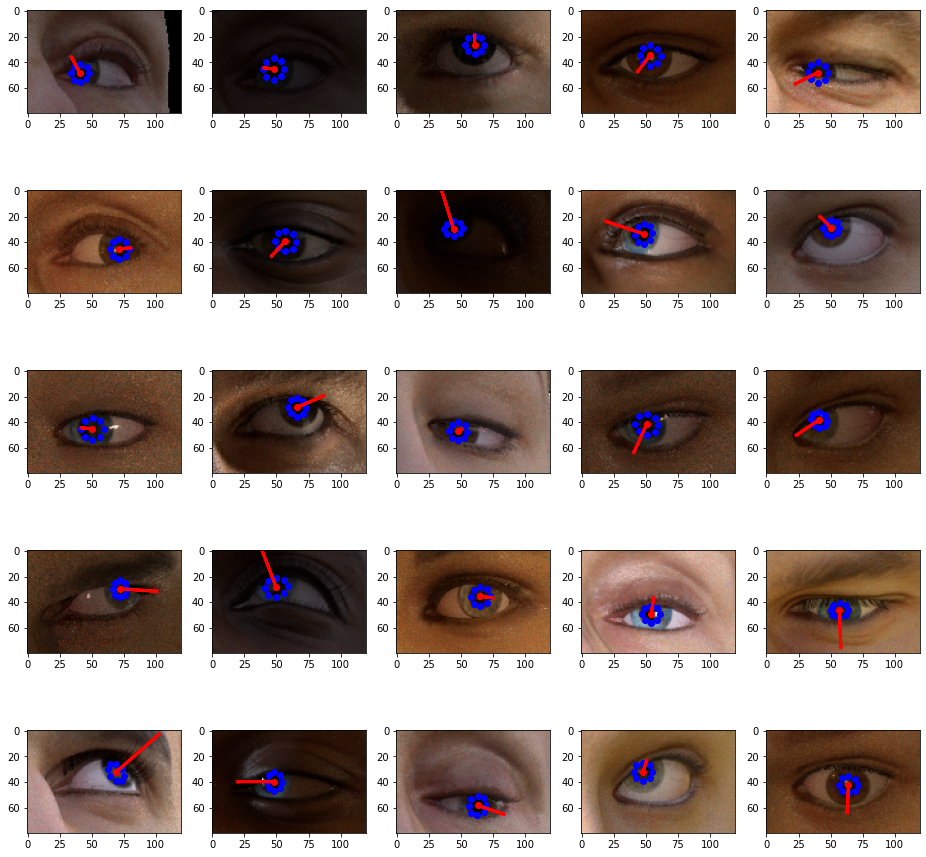

In [39]:
import random

def visualize_gaze(ax, reference_point, gaze_vector, eulers=False, length = 50, color='red'):
    if not eulers:
        x, y, z = gaze_vector
        yaw = np.arctan2(x, z)
        pitch = np.arctan2(y, z)
    else:
        yaw, pitch = gaze_vector
    dx = np.rint(length * np.sin(yaw))
    dy = np.rint(length * np.sin(pitch))
    ax.arrow(reference_point[0], reference_point[1], dx, dy, color=color, lw=3) 

def inspect_image(index, ax):
    sample_image = listed_images[index]
    sample_data = listed_data[index]
    
    image = imread(sample_image)
    image = image[:, :, [2, 1, 0]]
    data = None
    with open(sample_data, 'rb') as file:
        data = pickle.load(file)
    
    ax.imshow(image)
    pupil_landmarks = data['ldmks']['ldmks_pupil_2d']
    pupil_center = np.mean(pupil_landmarks, axis=0)
    
    visualize_gaze(ax, pupil_center, data['look_vec'])
    ax.scatter(pupil_center[0], pupil_center[1], color='red')
    ax.scatter(list(map(lambda x : x[0], pupil_landmarks)), list(map(lambda x : x[1], pupil_landmarks)), color = 'blue')

N, M = 5, 5

indexes = [random.randint(0, len(listed_images) - 1) for _ in range(N * M)]
fig, ax = plt.subplots(nrows=N, ncols=M, figsize=(16, 16))
for index, image in enumerate(indexes):
    inspect_image(image, ax[index // N, index % M])
plt.show()

## Pytorch map-style Dataset 

In [6]:
# Lets first try gaze-only dataset (w/o pupil center, for example)

def vector_to_angles(gaze_vector):
    """ 
    Input : gaze vector in camera coordinate system
    
    Returns :  yaw and pitch in camera coordinate system"""
    x, y, z = gaze_vector

    yaw = np.arctan2(x, z)
    pitch = np.arctan2(y, z)
    return yaw, pitch

class GazeOnlyDataset(torch.utils.data.Dataset):
    def __init__(self, images_path, pickles_path):
        self.size = len(images_path)
        # Store images in pytorch-like shape
        image_shape = (3, 80, 120) 
        
        self.images = np.empty((self.size, *(image_shape)), dtype=np.float32)
        self.gazes = np.empty((self.size, 2), dtype=np.float32)
        self.pupil_centers = np.empty((self.size, 2), dtype=np.int)
        
        pickle_data = None
        for index, (image_path, data_path) in tqdm.tqdm(enumerate(zip(images_path, pickles_path))):
            with open(data_path, 'rb') as file:
                pickle_data = pickle.load(file)
            # Swap channels since opev-cv loads everything in BGR format scale it as well, becuase 
            # images values have 'uint8' type
            self.images[index] = imread(image_path)[:, :, [2, 1, 0]].transpose(2, 0, 1) / 255
            self.gazes[index] = vector_to_angles(pickle_data['look_vec'])
            self.pupil_centers[index] = np.round(np.mean(pickle_data['ldmks']['ldmks_pupil_2d'], axis=0))
            
    def __getitem__(self, index):
        return (self.images[index], self.gazes[index], self.pupil_centers[index]) 
        
    def __len__(self):
        return self.size

## Pytorch Dataloader for training the neural network

In [7]:
def create_loader(images_path, pickles_path, 
                  batch_size = 32,
                  split_ratio = 0.9,
                  num_workers= 0,
                  pin_memory= False):
    size = len(images_path)
    assert size == len(pickles_path), \
    "Length of images {} doens't match associated data length {}".format(size, len(pickles_path))
    
    assert (split_ratio >= 0 and split_ratio < 1), "Split ration must lay in range of [0, 1)"
    
    right_border = np.int(split_ratio * size)
    
    train_images_path = images_path[: right_border]
    train_pickles_path = pickles_path[: right_border]
    
    test_images_path = images_path[right_border : ]
    test_pickles_path = pickles_path[right_border : ]
    
    train_data = GazeOnlyDataset(train_images_path, train_pickles_path)
    test_data = GazeOnlyDataset(test_images_path, test_pickles_path)
    
    train_loader = torch.utils.data.DataLoader(
        train_data,
        shuffle=True,
        batch_size=batch_size,
        num_workers=0,
        drop_last=True,
        pin_memory=pin_memory
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_data,
        shuffle=False,
        batch_size=batch_size,
        num_workers=num_workers,
        drop_last=False,
        pin_memory=pin_memory
    )
    return train_loader, test_loader

In [8]:
train_loader, test_loader = create_loader(listed_images, listed_data)

10243it [00:09, 1126.33it/s]
1139it [00:00, 1140.56it/s]


## GazeNet

This simple model which is inspired by architecture of neural net designed for pupil localization from 
NVidia NVGaze paper at

(CHI'19 : ACM CHI Conference on Human Factors in Computing Systems)

In [9]:
def init_weights(layer):
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight)
        nn.init.zeros_(layer.bias)
    elif isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight)
        nn.init.zeros_(layer.bias)
        
class GazeNet(nn.Module):
    def __init__(self):
        super(GazeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=[9, 9], stride=[2, 2]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=36, kernel_size=[7, 7], stride=[2, 2]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=36, out_channels=52, kernel_size=[5, 5], stride=[2, 2]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
    
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=52, out_channels=80, kernel_size=[5, 5], stride=[2, 2]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        
        self.conv5= nn.Sequential(
            nn.Conv2d(in_channels=80, out_channels=124, kernel_size=[3, 3], stride =[1, 1], padding=[1, 1]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=124, out_channels=256, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1]),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        
        self.flatten1 = nn.Flatten()
        self.dense1 = nn.Linear(512 * 4, 2)
        
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.conv2(x)
        
        x = self.conv3(x)
        
        x = self.conv4(x)
        
        x = self.conv5(x)
        
        x = self.conv6(x)
        
        x = self.conv7(x)
        
        x = self.flatten1(x)
        
        x = self.dense1(x)
        return x
model = GazeNet()
model.apply(init_weights)

GazeNet(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=[9, 9], stride=[2, 2])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(24, 36, kernel_size=[7, 7], stride=[2, 2])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(36, 52, kernel_size=[5, 5], stride=[2, 2])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(52, 80, kernel_size=[5, 5], stride=[2, 2])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv5): Sequential(
    (0): Conv2d(80, 124, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv6): Sequential(
    (0): Conv2d(124, 256, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1])
    (1): Dropout(p=0.1, inplace=False)
    (2): ReLU()
  )
  (conv7): Sequential(
    (0): Conv2d(256, 512, kernel_size=[3, 3], stride=[1, 1], padding=[1, 1])
    (1): Dr

In [10]:
%%time
dummy = torch.rand(32, 3, 120, 80)
print(model(dummy).shape)

torch.Size([32, 2])
CPU times: user 137 ms, sys: 46.5 ms, total: 184 ms
Wall time: 79.9 ms


### Setup device

It's either CPU or single GPU

In [11]:
use_gpu = True
device = "cuda:0" if use_gpu and torch.cuda.is_available() else "cpu"

print("Working device : ", end='')
if device == "cuda:0":
    print("GPU, - {}".format(torch.cuda.get_device_name(0)))
else:
    print("CPU")

Working device : CPU


### Average meter
Little utility class that helps to track loss progress in real time

In [12]:
class AverageMeter():
    def __init__(self):
        self.reset()
    def reset(self):
        self.count = 0
        self.average = 0
        self.sum = 0
        self.val = 0
    def update(self, val, num):
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count

In [13]:
def train(epoch, train_loader, model, optimizer, criterion, meter):
    model.train()
    model.to(device)
    
    train_size = len(train_loader)
    # For now we don't need pupil center for training
    for step, (images, gazes, _) in enumerate(iter(train_loader)):
        optimizer.zero_grad()
        
        images.to(device)
        gazes.to(device)
        
        predictions = model(images)
        loss = criterion(predictions, gazes)
        loss.backward()
        
        optimizer.step()
        
        size = images.size(0)
        meter.update(loss.item(), size)
        
        if step % 25 == 0:
            print("Epoch : {} ({}/{}), loss : {:.2f} ({})".format(epoch, step, train_size, meter.val, meter.avg))

In [37]:
# Lets sample from test_loader 25 examples, draw ground truth and 
# preicted labels
def draw_results(ax, image, pupil_center, gaze, prediction):
    ax.imshow(image)
    visualize_gaze(ax, pupil_center, gaze, eulers=True, color='red')
    visualize_gaze(ax, pupil_center, prediction, eulers=True, color='blue')

def test_and_save(test_loader, model, criterion, skip=1):
    model.eval()
    
    average_meter = AverageMeter()
    with torch.no_grad():
        for step, (images, gazes, pupil_centers) in tqdm.tqdm(enumerate(test_loader)):
            predictions = model(images)
            loss = criterion(predictions, gazes)
            
            size = images.size(0)
            average_meter.update(loss.item(), size)
            
            images = images[:25]
            gazes = gazes[:25]
            pupil_centers = pupil_centers[:25]
            predictions = None

            with torch.no_grad():
                predictions = model(images)
            N, M = 5, 5
            fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(24, 24))
            for index, (image, gaze, prediction, pupil_center) in enumerate(zip(images, gazes, predictions, pupil_centers)):
                # Since image is torch.tensor now, it's shape (C, H, W)
                draw_results(ax[index // N, index % M], image.permute(1, 2, 0), pupil_center, gaze, prediction)
            plt.savefig("predictions/gazes_predictions_{}.jpg".format(step))
            plt.close(fig)
    print("Test size : {}\nTest loss : {}".format(average_meter.count, average_meter.avg))

In [16]:
def main():
    model = GazeNet()
    model.to(device)
    
    # Parameters that are used here has same value
    # as in NVidia paper (except for amount of epochs and scheduler
    # because we use different dataset)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=1e-4,
        betas=[0.9, 0.99],
        eps=1e-8
    )
    criterion = torch.nn.L1Loss(reduction='mean')
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[140],
        gamma=1e-3
    )
    
    meter = AverageMeter()
    epochs = 150
    for epoch in range(1, epochs + 1):
        train(epoch, train_loader, model, optimizer, criterion, meter)
        scheduler.step()
        
        print("Epoch {} ended, current MAE: {}".format(epoch, meter.avg))
        print("Saving the model...")
        state_dict = model.state_dict()
        torch.save(state_dict, "models/model_state_{}.pth".format(epoch))
        print("Saved successfully")

In [29]:
main()

Epoch : 1 (0/320), loss on current batch : 2.85, average loss : 2.85
Epoch : 1 (25/320), loss on current batch : 2.76, average loss : 2.83
Epoch : 1 (50/320), loss on current batch : 2.77, average loss : 2.82
Epoch : 1 (75/320), loss on current batch : 2.84, average loss : 2.81
Epoch : 1 (100/320), loss on current batch : 2.73, average loss : 2.81
Epoch : 1 (125/320), loss on current batch : 2.87, average loss : 2.81
Epoch : 1 (150/320), loss on current batch : 2.84, average loss : 2.81
Epoch : 1 (175/320), loss on current batch : 2.60, average loss : 2.79
Epoch : 1 (200/320), loss on current batch : 2.64, average loss : 2.79
Epoch : 1 (225/320), loss on current batch : 2.74, average loss : 2.76
Epoch : 1 (250/320), loss on current batch : 2.27, average loss : 2.73
Epoch : 1 (275/320), loss on current batch : 2.19, average loss : 2.69
Epoch : 1 (300/320), loss on current batch : 2.26, average loss : 2.66
Saving the model...
Saved successfully
Epoch : 2 (0/320), loss on current batch : 

Epoch : 9 (200/320), loss on current batch : 1.23, average loss : 1.25
Epoch : 9 (225/320), loss on current batch : 0.90, average loss : 1.27
Epoch : 9 (250/320), loss on current batch : 0.60, average loss : 1.24
Epoch : 9 (275/320), loss on current batch : 1.06, average loss : 1.23
Epoch : 9 (300/320), loss on current batch : 1.02, average loss : 1.23
Saving the model...
Saved successfully
Epoch : 10 (0/320), loss on current batch : 1.45, average loss : 1.45
Epoch : 10 (25/320), loss on current batch : 0.68, average loss : 1.13
Epoch : 10 (50/320), loss on current batch : 1.32, average loss : 1.20
Epoch : 10 (75/320), loss on current batch : 1.49, average loss : 1.27
Epoch : 10 (100/320), loss on current batch : 1.01, average loss : 1.28
Epoch : 10 (125/320), loss on current batch : 0.99, average loss : 1.22
Epoch : 10 (150/320), loss on current batch : 1.13, average loss : 1.20
Epoch : 10 (175/320), loss on current batch : 0.91, average loss : 1.17
Epoch : 10 (200/320), loss on curre

Epoch : 18 (25/320), loss on current batch : 0.26, average loss : 0.82
Epoch : 18 (50/320), loss on current batch : 0.90, average loss : 0.85
Epoch : 18 (75/320), loss on current batch : 1.13, average loss : 0.88
Epoch : 18 (100/320), loss on current batch : 0.91, average loss : 0.87
Epoch : 18 (125/320), loss on current batch : 0.71, average loss : 0.80
Epoch : 18 (150/320), loss on current batch : 0.77, average loss : 0.78
Epoch : 18 (175/320), loss on current batch : 0.34, average loss : 0.78
Epoch : 18 (200/320), loss on current batch : 0.99, average loss : 0.80
Epoch : 18 (225/320), loss on current batch : 0.60, average loss : 0.82
Epoch : 18 (250/320), loss on current batch : 0.29, average loss : 0.81
Epoch : 18 (275/320), loss on current batch : 0.72, average loss : 0.80
Epoch : 18 (300/320), loss on current batch : 0.77, average loss : 0.80
Saving the model...
Saved successfully
Epoch : 19 (0/320), loss on current batch : 0.76, average loss : 0.76
Epoch : 19 (25/320), loss on c

Epoch : 26 (200/320), loss on current batch : 0.89, average loss : 0.59
Epoch : 26 (225/320), loss on current batch : 0.30, average loss : 0.61
Epoch : 26 (250/320), loss on current batch : 0.20, average loss : 0.60
Epoch : 26 (275/320), loss on current batch : 0.65, average loss : 0.60
Epoch : 26 (300/320), loss on current batch : 0.58, average loss : 0.60
Saving the model...
Saved successfully
Epoch : 27 (0/320), loss on current batch : 0.50, average loss : 0.50
Epoch : 27 (25/320), loss on current batch : 0.20, average loss : 0.73
Epoch : 27 (50/320), loss on current batch : 0.75, average loss : 0.68
Epoch : 27 (75/320), loss on current batch : 0.93, average loss : 0.68
Epoch : 27 (100/320), loss on current batch : 0.68, average loss : 0.67
Epoch : 27 (125/320), loss on current batch : 0.52, average loss : 0.61
Epoch : 27 (150/320), loss on current batch : 0.46, average loss : 0.60
Epoch : 27 (175/320), loss on current batch : 0.26, average loss : 0.59
Epoch : 27 (200/320), loss on 

Epoch : 35 (25/320), loss on current batch : 0.22, average loss : 0.56
Epoch : 35 (50/320), loss on current batch : 0.41, average loss : 0.50
Epoch : 35 (75/320), loss on current batch : 0.49, average loss : 0.52
Epoch : 35 (100/320), loss on current batch : 0.36, average loss : 0.51
Epoch : 35 (125/320), loss on current batch : 0.76, average loss : 0.47
Epoch : 35 (150/320), loss on current batch : 0.29, average loss : 0.45
Epoch : 35 (175/320), loss on current batch : 0.22, average loss : 0.45
Epoch : 35 (200/320), loss on current batch : 0.91, average loss : 0.47
Epoch : 35 (225/320), loss on current batch : 0.29, average loss : 0.48
Epoch : 35 (250/320), loss on current batch : 0.22, average loss : 0.47
Epoch : 35 (275/320), loss on current batch : 0.86, average loss : 0.47
Epoch : 35 (300/320), loss on current batch : 0.56, average loss : 0.47
Saving the model...
Saved successfully
Epoch : 36 (0/320), loss on current batch : 0.27, average loss : 0.27
Epoch : 36 (25/320), loss on c

Epoch : 43 (200/320), loss on current batch : 0.76, average loss : 0.39
Epoch : 43 (225/320), loss on current batch : 0.32, average loss : 0.39
Epoch : 43 (250/320), loss on current batch : 0.21, average loss : 0.39
Epoch : 43 (275/320), loss on current batch : 0.57, average loss : 0.39
Epoch : 43 (300/320), loss on current batch : 0.49, average loss : 0.39
Saving the model...
Saved successfully
Epoch : 44 (0/320), loss on current batch : 0.31, average loss : 0.31
Epoch : 44 (25/320), loss on current batch : 0.20, average loss : 0.47
Epoch : 44 (50/320), loss on current batch : 0.47, average loss : 0.41
Epoch : 44 (75/320), loss on current batch : 0.24, average loss : 0.43
Epoch : 44 (100/320), loss on current batch : 0.33, average loss : 0.42
Epoch : 44 (125/320), loss on current batch : 0.32, average loss : 0.39
Epoch : 44 (150/320), loss on current batch : 0.26, average loss : 0.38
Epoch : 44 (175/320), loss on current batch : 0.15, average loss : 0.38
Epoch : 44 (200/320), loss on 

Epoch : 52 (25/320), loss on current batch : 0.28, average loss : 0.40
Epoch : 52 (50/320), loss on current batch : 0.53, average loss : 0.39
Epoch : 52 (75/320), loss on current batch : 0.55, average loss : 0.42
Epoch : 52 (100/320), loss on current batch : 0.40, average loss : 0.42
Epoch : 52 (125/320), loss on current batch : 0.45, average loss : 0.40
Epoch : 52 (150/320), loss on current batch : 0.41, average loss : 0.39
Epoch : 52 (175/320), loss on current batch : 0.14, average loss : 0.39
Epoch : 52 (200/320), loss on current batch : 0.95, average loss : 0.39
Epoch : 52 (225/320), loss on current batch : 0.27, average loss : 0.39
Epoch : 52 (250/320), loss on current batch : 0.12, average loss : 0.39
Epoch : 52 (275/320), loss on current batch : 0.36, average loss : 0.39
Epoch : 52 (300/320), loss on current batch : 0.47, average loss : 0.39
Saving the model...
Saved successfully
Epoch : 53 (0/320), loss on current batch : 0.51, average loss : 0.51
Epoch : 53 (25/320), loss on c

Epoch : 60 (200/320), loss on current batch : 0.94, average loss : 0.33
Epoch : 60 (225/320), loss on current batch : 0.26, average loss : 0.33
Epoch : 60 (250/320), loss on current batch : 0.11, average loss : 0.33
Epoch : 60 (275/320), loss on current batch : 0.35, average loss : 0.34
Epoch : 60 (300/320), loss on current batch : 0.49, average loss : 0.33
Saving the model...
Saved successfully
Epoch : 61 (0/320), loss on current batch : 0.48, average loss : 0.48
Epoch : 61 (25/320), loss on current batch : 0.18, average loss : 0.37
Epoch : 61 (50/320), loss on current batch : 0.45, average loss : 0.37
Epoch : 61 (75/320), loss on current batch : 0.34, average loss : 0.40
Epoch : 61 (100/320), loss on current batch : 0.31, average loss : 0.38
Epoch : 61 (125/320), loss on current batch : 0.33, average loss : 0.36
Epoch : 61 (150/320), loss on current batch : 0.44, average loss : 0.34
Epoch : 61 (175/320), loss on current batch : 0.12, average loss : 0.33
Epoch : 61 (200/320), loss on 

Epoch : 69 (25/320), loss on current batch : 0.20, average loss : 0.36
Epoch : 69 (50/320), loss on current batch : 0.48, average loss : 0.32
Epoch : 69 (75/320), loss on current batch : 0.21, average loss : 0.37
Epoch : 69 (100/320), loss on current batch : 0.25, average loss : 0.35
Epoch : 69 (125/320), loss on current batch : 0.49, average loss : 0.33
Epoch : 69 (150/320), loss on current batch : 0.38, average loss : 0.32
Epoch : 69 (175/320), loss on current batch : 0.13, average loss : 0.32
Epoch : 69 (200/320), loss on current batch : 0.63, average loss : 0.32
Epoch : 69 (225/320), loss on current batch : 0.12, average loss : 0.32
Epoch : 69 (250/320), loss on current batch : 0.12, average loss : 0.33
Epoch : 69 (275/320), loss on current batch : 0.25, average loss : 0.33
Epoch : 69 (300/320), loss on current batch : 0.41, average loss : 0.32
Saving the model...
Saved successfully
Epoch : 70 (0/320), loss on current batch : 0.22, average loss : 0.22
Epoch : 70 (25/320), loss on c

In [17]:
model = GazeNet()
state_dict = torch.load("models/model_state_70.pth") 
model.load_state_dict(state_dict)

<All keys matched successfully>

In [36]:
criterion = nn.L1Loss(reduction='mean')
test_and_save(test_loader, model, criterion)

36it [01:12,  2.02s/it]

Test size : 1139
Test loss : 0.9077902869031134


## ToDo

• Implement pupil center detection using another dense layer

• Evaluate model in real environment

• Apply augmentation <b> only if </b> models works bad during inference time